In [6]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [15]:
ROC_m1 = r'/Volumes/PhD/imagery/masters/ROC/M1_CT_ROC.shp'
ROC_m1 = gpd.read_file(ROC_m1)
ROC_m1.columns

ROC_msm1 = r'/Volumes/PhD/imagery/masters/output/ROC/MSM1_ROC.csv'
ROC_msm1 = pd.read_csv(ROC_msm1, index_col=0)
ROC_msm1

,BASIN_ID,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1_>50,MSM1_>90
0,17499,0.452268,0.454098,0.434946,0.338655,0.000000
1,3115,0.167113,0.116710,0.103580,0.000000,0.000000
2,3589,0.347361,0.164258,0.126322,0.350926,0.000926
3,5683,0.998348,0.999251,0.999311,1.000000,1.000000
4,5920,0.816237,0.870989,0.913444,0.939107,0.355948
...,...,...,...,...,...,...
732,15065,0.340194,0.248064,0.187487,0.258333,0.000000
733,35852,0.473233,0.466838,0.442397,0.297561,0.000000
734,36553,0.468544,0.457159,0.447535,0.286957,0.000000
735,36955,0.293276,0.274903,0.235123,0.036496,0.000000


In [16]:
ROC_df = {
    'BASIN_ID': ROC_m1['BASIN_ID'],
    'M1P_Mean': ROC_m1['M1P_Mean'],
    'M1P_Med': ROC_m1['M1P_Med'],
    'M1P_PF': ROC_m1['M1p_PF'],
    'MSM1P_Mean': ROC_msm1['MSM1P_Mean'],
    'MSM1P_Med': ROC_msm1['MSM1P_Med'],
    'MSM1P_PF': ROC_msm1['MSM1P_PF'],
    'MSM1Pct_>50': ROC_msm1['MSM1_>50'],
    'MSM1Pct_>90': ROC_msm1['MSM1_>90'],
    'RI': ROC_m1['RI'],
    'Old_ROC': ROC_m1['Field']
}
ROC_df = pd.DataFrame(ROC_df)
ROC_df

,BASIN_ID,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>90,RI,Old_ROC
0,17499,0.449618,0.454098,0.438860,0.452268,0.454098,0.434946,0.338655,0.000000,5.08,1
1,3115,0.148129,0.116710,0.101142,0.167113,0.116710,0.103580,0.000000,0.000000,7.11,4
2,3589,0.301476,0.164258,0.122691,0.347361,0.164258,0.126322,0.350926,0.000926,7.11,4
3,5683,0.999180,0.999251,0.999382,0.998348,0.999251,0.999311,1.000000,1.000000,12.95,4
4,5920,0.848432,0.870989,0.910869,0.816237,0.870989,0.913444,0.939107,0.355948,6.10,4
...,...,...,...,...,...,...,...,...,...,...,...
732,15065,0.313190,0.248063,0.189564,0.340194,0.248064,0.187487,0.258333,0.000000,9.14,0
733,35852,0.473049,0.466838,0.444912,0.473233,0.466838,0.442397,0.297561,0.000000,7.37,0
734,36553,0.468316,0.457159,0.448097,0.468544,0.457159,0.447535,0.286957,0.000000,7.37,0
735,36955,0.281668,0.274903,0.249830,0.293276,0.274903,0.235123,0.036496,0.000000,7.37,0


In [18]:
#Ground truth category
ROC_df['DF'] = ROC_df['Old_ROC'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

#M1 ROC setup
ROC_df['M1_Mean_50'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Med_50'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_PF_50'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Mean_90'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_Med_90'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_PF_90'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC setup
ROC_df['MSM1_Mean_50'] = ROC_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_Med_50'] = ROC_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_PF_50'] = ROC_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_Mean_90'] = ROC_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['MSM1_Med_90'] = ROC_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['MSM1_PF_90'] = ROC_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC basin pct above 50 & 90 setup

ROC_df['MSM1_Pct_50'] = ROC_df['MSM1Pct_>50'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['MSM1_Pct_90'] = ROC_df['MSM1Pct_>90'].apply(lambda x: 1 if x > 0.5 else 0)


In [19]:
ROC_df

,BASIN_ID,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>90,RI,...,M1_Med_90,M1_PF_90,MSM1_Mean_50,MSM1_Med_50,MSM1_PF_50,MSM1_Mean_90,MSM1_Med_90,MSM1_PF_90,MSM1_Pct_50,MSM1_Pct_90
0,17499,0.449618,0.454098,0.438860,0.452268,0.454098,0.434946,0.338655,0.000000,5.08,...,0,0,0,0,0,0,0,0,0,0
1,3115,0.148129,0.116710,0.101142,0.167113,0.116710,0.103580,0.000000,0.000000,7.11,...,0,0,0,0,0,0,0,0,0,0
2,3589,0.301476,0.164258,0.122691,0.347361,0.164258,0.126322,0.350926,0.000926,7.11,...,0,0,0,0,0,0,0,0,0,0
3,5683,0.999180,0.999251,0.999382,0.998348,0.999251,0.999311,1.000000,1.000000,12.95,...,1,1,1,1,1,1,1,1,1,1
4,5920,0.848432,0.870989,0.910869,0.816237,0.870989,0.913444,0.939107,0.355948,6.10,...,0,1,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,0.313190,0.248063,0.189564,0.340194,0.248064,0.187487,0.258333,0.000000,9.14,...,0,0,0,0,0,0,0,0,0,0
733,35852,0.473049,0.466838,0.444912,0.473233,0.466838,0.442397,0.297561,0.000000,7.37,...,0,0,0,0,0,0,0,0,0,0
734,36553,0.468316,0.457159,0.448097,0.468544,0.457159,0.447535,0.286957,0.000000,7.37,...,0,0,0,0,0,0,0,0,0,0
735,36955,0.281668,0.274903,0.249830,0.293276,0.274903,0.235123,0.036496,0.000000,7.37,...,0,0,0,0,0,0,0,0,0,0


In [20]:
ROC_df.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC.csv')


In [21]:
def compute_roc(df, ground_truth, prediction_col):
    results = []

    for pred_col in prediction_col:
        TP = ((df[ground_truth] == 1) & (df[pred_col] == 1)).sum()
        FP = ((df[ground_truth] == 0) & (df[pred_col] == 1)).sum()
        TN = ((df[ground_truth] == 0) & (df[pred_col] == 0)).sum()
        FN = ((df[ground_truth] == 1) & (df[pred_col] == 0)).sum()

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        SPC = TN / (TN + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)

        # Calculate AUC using scikit-learn's roc_curve and auc functions
        fpr, tpr, _ = roc_curve(df[ground_truth], df[pred_col])
        roc_auc = auc(fpr, tpr)

        # Append results
        results.append({
            "Prediction Column": pred_col,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "Sensitivity": TPR,
            "FPR": FPR,
            'Specificity': SPC,
            'Accuracy': ACC,
            "AUC": roc_auc
        })
    return pd.DataFrame(results)

In [23]:
columns_after_df = ROC_df.columns[ROC_df.columns.get_loc('DF') + 1:]
columns_after_df


Index(['M1_Mean_50', 'M1_Med_50', 'M1_PF_50', 'M1_Mean_90', 'M1_Med_90',
       'M1_PF_90', 'MSM1_Mean_50', 'MSM1_Med_50', 'MSM1_PF_50', 'MSM1_Mean_90',
       'MSM1_Med_90', 'MSM1_PF_90', 'MSM1_Pct_50', 'MSM1_Pct_90'],
      dtype='object')

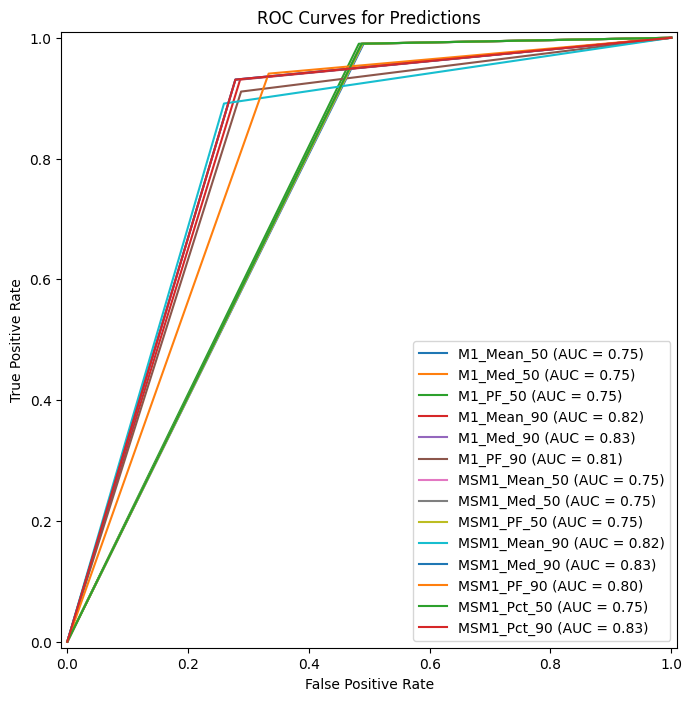

In [ ]:
ground_truth_col = 'DF'
roc_results = compute_roc(ROC_df, ground_truth_col, columns_after_df)



# Optional: Plot ROC curves for each column
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for pred_col in columns_after_df:
    fpr, tpr, _ = roc_curve(ROC_df['DF'], ROC_df[pred_col])
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=pred_col).plot(ax=plt.gca())

plt.title('ROC M1 & MSM1 Modeling')
plt.legend(loc='lower right')
plt.show()

In [26]:
roc_results


,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC
0,M1_Mean_50,100,312,324,1,0.990099,0.490566,0.509434,0.575305,0.749766
1,M1_Med_50,100,310,326,1,0.990099,0.487421,0.512579,0.578019,0.751339
2,M1_PF_50,100,307,329,1,0.990099,0.482704,0.517296,0.582090,0.753697
3,M1_Mean_90,94,182,454,7,0.930693,0.286164,0.713836,0.743555,0.822265
4,M1_Med_90,94,177,459,7,0.930693,0.278302,0.721698,0.750339,0.826196
5,M1_PF_90,92,183,453,9,0.910891,0.287736,0.712264,0.739484,0.811578
6,MSM1_Mean_50,100,311,325,1,0.990099,0.488994,0.511006,0.576662,0.750553
7,MSM1_Med_50,100,310,326,1,0.990099,0.487421,0.512579,0.578019,0.751339
8,MSM1_PF_50,100,311,325,1,0.990099,0.488994,0.511006,0.576662,0.750553
9,MSM1_Mean_90,90,165,471,11,0.891089,0.259434,0.740566,0.761194,0.815828


In [27]:
roc_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_results.csv')
